### Deep learning with Pretrained Word2Vec Vectors 
We will combine the 1D Convolutional model with Stanford's pre-trained GloVe vectors, which should have a much larger vocabulary and more accurate representations of word similarity than we have in our own small vocabulary.  


In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas
#!pip install pyspark==2.4.5
!pip install -U scikit-learn
!pip install gensim

     |████████████████████████████████| 14.5MB 7.9MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 10.5MB 5.5MB/s eta 0:00:01
ERROR: ibm-watson-machine-learning 1.0.10 has requirement pandas<=0.25.3, but you'll have pandas 1.1.2 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
     |████████████████████████████████| 6.8MB 5.6MB/s eta 0:00:01     |████████████████████████████████| 6.8MB 5.6MB/s 
     |████████████████████████████████| 307kB 39.3MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.23.2 which is incom

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import string
import re
from datetime import datetime
from packaging import version

from ibm_botocore.client import Config
import ibm_boto3

from sklearn.model_selection import train_test_split
#pd.show_versions()

In [3]:
#Get our data from IBM Cloud

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_news = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    #'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'ENDPOINT':'https://s3-api.us-geo.objectstorage.softlayer.net',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'dfTrueFalseNews.pkl'
}

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')
        
dfNews = download_file_cos(credentials_news, "dfTrueFalseNews.pkl", "dfTrueFalseNews.pkl")
dfTrueFalseNews_tokenized  = download_file_cos(credentials_news,'dfTrueFalseNews_tokenized.pkl','dfTrueFalseNews_tokenized.pkl')

File Downloaded
File Downloaded


In [8]:
dfNewsTemp = pd.read_pickle('dfTrueFalseNews.pkl')
dfTrueFalseNews_tokenized = pd.read_pickle('dfTrueFalseNews_tokenized.pkl')
#dfNews['truthvalue'] = pd.Categorical(dfNews['truthvalue'])

x = dfNewsTemp['text'].values

y = dfNewsTemp['truthvalue'].values

print (dfNewsTemp.shape, dfNewsTemp.columns, '\n', dfNewsTemp.dtypes, type(x), type(y))


(1126, 3) Index(['text', 'source', 'truthvalue'], dtype='object') 
 text          object
source        object
truthvalue    object
dtype: object <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Download the pretrained vectors
This is the Stanford GloVe embedding
We download it and unzip it.  Then save the zipped file in case we need it tomorrow.

In [4]:
#!curl http://nlp.stanford.edu/data/glove.6B.zip --output glove.6B.zip -L
download_file_cos(credentials_news, "glove.6B.zip", "glove.6B.zip")
#!ls -al
!unzip glove.6B.zip glove.6B.300d.txt
#!ls -al
#upload_file_cos(credentials_news, "glove.6B.zip", "glove.6B.zip")
!rm glove.6B.zip
!ls -al

File Downloaded
Archive:  glove.6B.zip
  inflating: glove.6B.300d.txt       
total 1020864
drwxr-x--- 2 dsxuser dsxuser       4096 Sep 19 19:27 .
drwx------ 1 dsxuser dsxuser       4096 Sep 19 19:24 ..
-rw-r----- 1 dsxuser dsxuser    2228457 Sep 19 19:25 dfTrueFalseNews.pkl
-rw-r----- 1 dsxuser dsxuser    5159678 Sep 19 19:25 dfTrueFalseNews_tokenized.pkl
-rw-rw-r-- 1 dsxuser dsxuser 1037962819 Aug 27  2014 glove.6B.300d.txt


### Prepare the Text for Word2Vec
1. Change all the text to lower case
2. Split stories into sentences.
3. Word Tokenization and removing non-alpha text.

In [5]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import wordnet as wn
from collections import defaultdict
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# reproduce the same result every time the script is run.
np.random.seed(500)

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
from gensim.models import Word2Vec
from string import punctuation
from os import listdir
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.data import Dataset

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/frame

### Use Stanford GloVe Word2Vec vectors as embedding layer for Deep Learning model

In [12]:
# Split into Train_X, Train_Y, Test_X, Test_Y
from sklearn import model_selection
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(dfNewsTemp['text'],dfNewsTemp['truthvalue'],test_size=0.1)
train_docs = tokenizer = test_docs = encoded_docs = None

In [13]:
len(Train_X), len(Test_X), len(Train_Y), len(Test_Y)

(1013, 113, 1013, 113)

In [21]:
# Use the Stanford GloVe word2vec vocabulary as input to the embedding layer.

from gensim.models import Word2Vec
from numpy import array
from numpy import asarray
from numpy import zeros

wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

from nltk.corpus import wordnet


# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #tokens = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokens] # the prepared embedding has all forms of verbs, so this isn't neccesary.
    
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(x, vocab):
    documents = list()
    # walk through all files in the folder
    #for filename in listdir(directory):
    for doc in x:
        # skip any reviews in the test set
        #if is_trian and filename.startswith('cv9'):
        #    continue
        #if not is_train: # and not filename.startswith('cv9'):
        #    continue
        # create the full path of the file to open
        #path = directory + '/' + filename
        # load the doc
        #doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

# load the vocabulary
download_file_cos(credentials_news,'vocab.txt','vocab.txt')
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training stories
print ("processing training docs")
train_docs = process_docs(Train_X, vocab)


# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
print ("Found max_length ", max_length)
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = Train_Y # array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
test_docs = process_docs(Test_X, vocab)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = Test_Y 

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# load embedding from file

#load GloVe embedding
embeddingword2vec_fn = 'glove.6B.100d.txt'
download_file_cos(credentials_news, embeddingword2vec_fn, embeddingword2vec_fn)
raw_embedding = load_embedding(embeddingword2vec_fn)
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
print (len(Xtrain), len(ytrain), len(Xtest), len(ytest))
history = model.fit(Xtrain, ytrain, epochs=6, validation_data=(Xtest, ytest))
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f Loss: %f' % (acc*100, loss * 100 ))


File Downloaded
processing training docs
<class 'Exception'> An error occurred (404) when calling the HeadObject operation: Not Found
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 6347, 100)         752000    
_________________________________________________________________
conv1d (Conv1D)              (None, 6343, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3171, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 405888)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 405889    
Total params: 1,222,017
Trainable params: 470,017
Non-trainable para

In [15]:
from gensim.models import Word2Vec
from numpy import array
from numpy import asarray
from numpy import zeros

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding


def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

#load GloVe embedding
embeddingword2vec_fn = 'glove.6B.300d.txt'
#download_file_cos(credentials_news, embeddingword2vec_fn, embeddingword2vec_fn)
raw_embedding = load_embedding(embeddingword2vec_fn)
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)

# create a weight matrix for the Embedding layer from a loaded embedding


AttributeError: 'NoneType' object has no attribute 'word_index'

In [27]:
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #tokens = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in tokens] # the prepared embedding has all forms of verbs, so this isn't neccesary.
    
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    
    tokens = ' '.join(tokens)
    return tokens

clean_doc(Train_X[0])

TypeError: clean_doc() missing 1 required positional argument: 'vocab'

In [ ]:
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = Train_Y # array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
test_docs = process_docs(Test_X, vocab)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)

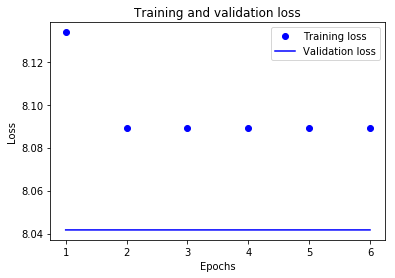

In [61]:
history_dict = history.history
history_dict.keys()

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

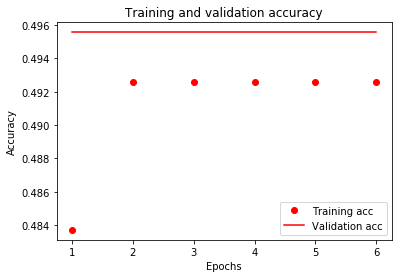

In [62]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()